In [1]:
# Basic libraries
import sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning related imports
import optuna
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
# Classifiers used 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# Suppress warnings
import warnings 
warnings.filterwarnings('ignore')
# Custom functions
sys.path.append('../src')
from custom_functions import compute_metrics 

/home/eleni/anaconda3/envs/sc_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load our data
adata_original = sc.read_h5ad("../data/pooled_data/mouse_tissuewise_pooled.h5ad")

In [3]:
# Shuffle data
np.random.seed(42)
adata = adata_original[np.random.permutation(adata_original.obs_names)]

# Split train and test set 60-40%, uses stratified kfold 
train_indices, test_indices = train_test_split(
    np.arange(adata.n_obs),
    test_size=0.4
)

In [4]:
adata_train = adata[train_indices].copy()
adata_test = adata[test_indices].copy()

print(adata_train)
print(adata_test)

AnnData object with n_obs × n_vars = 4929 × 7760
    obs: 'sample', 'n_genes'
AnnData object with n_obs × n_vars = 3286 × 7760
    obs: 'sample', 'n_genes'


**Class imbalance**

Check class balance in the datasets and corroborate if the samples for test and train are representative of the original dataset in terms of class ratio

In [5]:
# Check data for imbalance

def class_representation(adata_obj, class_col, dataset_type):

    y = adata_obj.obs[class_col]
    label_counts = y.values.value_counts()

    # Plotting
    plt.figure(figsize=(8, 6))

    bars = label_counts.plot(kind='bar', color=['blue', 'green'])

    # Annotate each bar with its count value
    for bar in bars.patches:
        plt.text(bar.get_x() + bar.get_width() / 2, 
                bar.get_height() + 1,             
                f'{bar.get_height()}',             
                ha='center',                        
                va='center',                        
                fontsize=10,                        
                color='black')                      

    plt.title(f'Sample Counts by class in {dataset_type}')
    plt.xlabel('Sample Type')
    plt.ylabel('Count')
    plt.show()

Original dataset before splitting

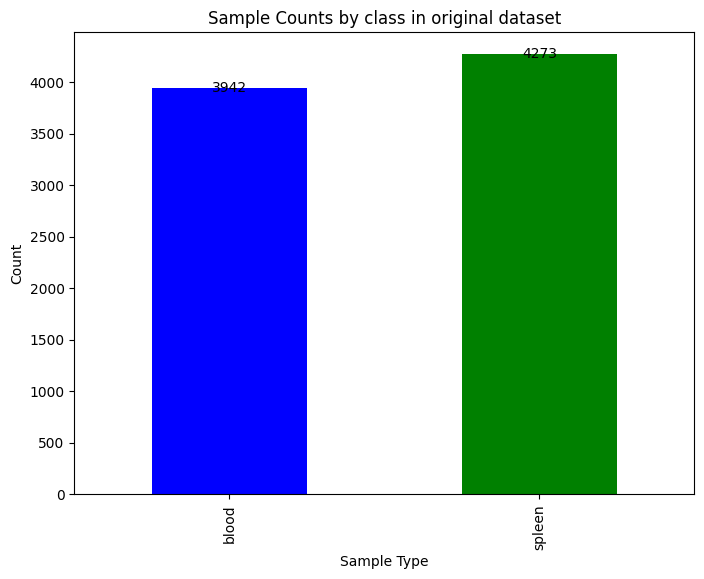

In [6]:
class_representation(adata, 'sample', 'original dataset')

Train test

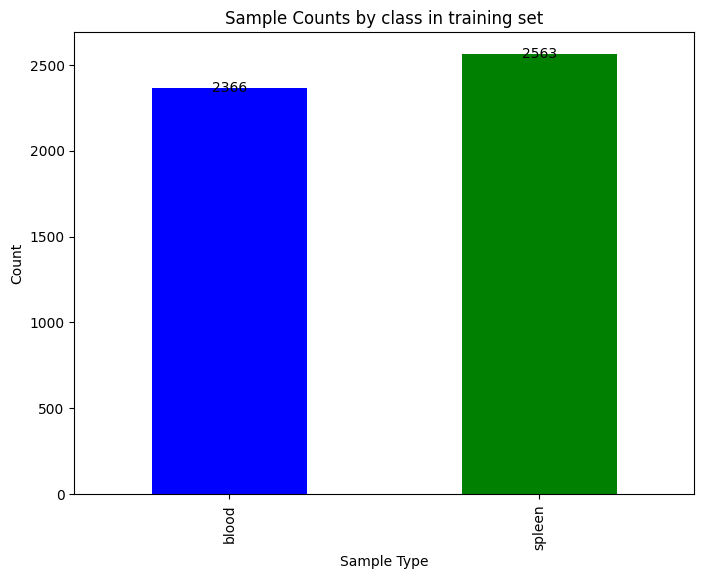

In [7]:
class_representation(adata_train, 'sample', 'training set')

Test set

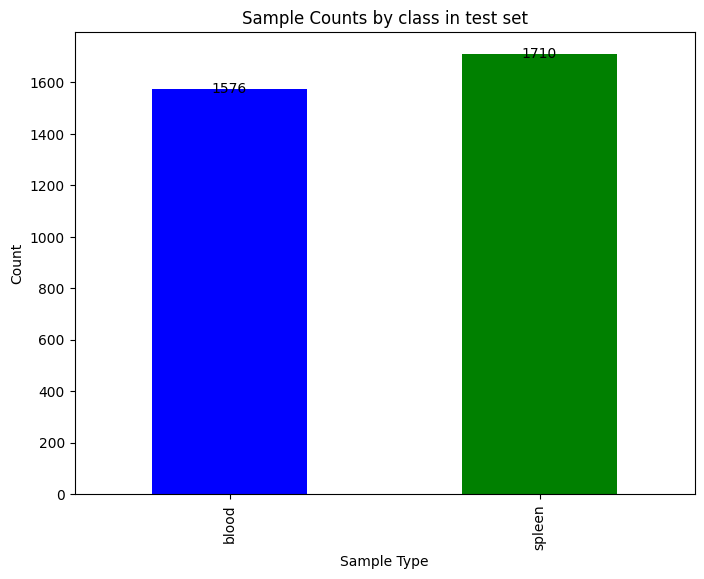

In [8]:
class_representation(adata_test, 'sample', 'test set')

**Preprocess**

In order to separately preprocess the train and the test set, we create the class `SingleCellPreprocessor` that first normalizes, then log transforms and lastly, scales the data in order to prepare them for the machine learning pipiline.

In [9]:
class SingleCellPreprocessor:
    def __init__(self, adata_train, adata_test):
        self.adata_train = adata_train
        self.adata_test = adata_test

    def norm_log(self, adata):
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        return adata

    def scale_data(self, adata):
        scaler = StandardScaler()
        adata.X = scaler.fit_transform(adata.X)
        return adata

    def preprocess(self):
        self.adata_train = self.norm_log(self.adata_train)
        self.adata_train = self.scale_data(self.adata_train)
        self.adata_test = self.norm_log(self.adata_test)
        self.adata_test = self.scale_data(self.adata_test)
        return self.adata_train, self.adata_test

In [10]:
preprocessor = SingleCellPreprocessor(adata_train, adata_test)
adata_train, adata_test = preprocessor.preprocess()

In [11]:
# adata_train.X

**No feature selection employed**

We split the dataset before normalization to prevent data leakage. Consequently, we preprocess the training set and the test set separately.

In [12]:
X_train = adata_train.X
y_tr = adata_train.obs['sample']
X_test = adata_test.X
y_ts = adata_test.obs['sample']

**Data encoded labels**

In [13]:
y_train = y_tr.values.to_list()
y_test = y_ts.values.to_list()

# convert categorical labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [14]:
# class encoding inspection

print(label_encoder.classes_)
print(dict(enumerate(label_encoder.classes_)))

['blood' 'spleen']
{0: 'blood', 1: 'spleen'}


**Feature selection**

We perform feature selection by choosing the top 20 features from the training data after splitting into train and test sets. This approach is grounded in 2 key reasons:

- Enhanced statistical power: With abundant data in both the training and test sets, feature selection methods benefit from heightened statistical power. This means they are better equipped to discern genuinely relevant features that significantly contribute to the model's predictive capabilities. Specifically, we use f_classif, which uses Analysis of Variance (ANOVA) F-test to evaluate each feature's significance in distinguishing between different classes in classification tasks. This method minimizes the risk of selecting features based on chance correlations or noise, ensuring that the chosen features are robust and meaningful.

- Avoid data leakage: Performing feature selection after the train-test split helps to prevent data leakage. Data leakage can occur when information from the test set inadvertently influences the training process, leading to overly optimistic performance estimates. By conducting feature selection exclusively on the training data, we ensure that the model is evaluated on genuinely unseen data during testing. This practice provides a more accurate assessment of the model's ability to generalize to new, unseen examples.

In [15]:
from sklearn.feature_selection import SelectKBest, f_classif

k = 20 # top features to select
selector = SelectKBest(f_classif, k=k)
X_train_fs = selector.fit_transform(X_train, y_train_encoded)
X_test_fs = selector.transform(X_test)

# print(X_train_fs)
# print(X_test_fs)

In [16]:
X_train_fs.shape

(4929, 20)

In [17]:
class ModelOptimizer:
    def __init__(self, X_train, y_train, X_test, y_test, random_state, label_encoder=None):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.random_state = random_state
        self.label_encoder = label_encoder
        self.best_models = {}
        self.best_metrics = {}
        self.trial_metrics = {}
        

    def objective(self, trial, classifier_name):
        if classifier_name.upper() == 'RANDOM FOREST':
            n_estimators = trial.suggest_int('n_estimators', 50, 200)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
            clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=self.random_state
            )
        
        elif classifier_name.upper() == 'SVC':
            C = trial.suggest_loguniform('C', 1e-10, 1e10)
            gamma = trial.suggest_loguniform('gamma', 1e-10, 1e1)
            clf = SVC(
                C=C,
                gamma=gamma,
                random_state=self.random_state
            )
        
        elif classifier_name.upper() == 'LOGISTIC REGRESSION':
            C = trial.suggest_loguniform('C', 1e-5, 1e5)
            penalty = trial.suggest_categorical('penalty', ['l2'])
            clf = LogisticRegression(
                C=C,
                penalty=penalty,
                solver='liblinear',
                random_state=self.random_state
            )
        
        elif classifier_name.upper() == 'KNN':
            n_neighbors = trial.suggest_int('n_neighbors', 3, 20)
            weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
            clf = KNeighborsClassifier(
                n_neighbors=n_neighbors,
                weights=weights
            )
        
        else:
            raise ValueError(f"Unknown classifier: {classifier_name}")

        score = cross_val_score(clf, self.X_train, self.y_train, cv=5, scoring='accuracy').mean()

        if classifier_name not in self.trial_metrics:
            self.trial_metrics[classifier_name] = []
            self.trial_metrics[classifier_name].append(score)
        else:
            self.trial_metrics[classifier_name].append(score)

        return score

    def optimize(self, classifier_name, n_trials=5):
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: self.objective(trial, classifier_name), n_trials=n_trials)
        self.best_models[classifier_name] = study.best_params
        return study.best_params

    def train_best_model(self, classifier_name):
        if classifier_name.upper() == 'RANDOM FOREST':
            best_model = RandomForestClassifier(**self.best_models[classifier_name], random_state=self.random_state)
        elif classifier_name.upper() == 'SVC':
            best_model = SVC(**self.best_models[classifier_name], random_state=self.random_state)
        elif classifier_name.upper() == 'LOGISTIC REGRESSION':
            best_model = LogisticRegression(**self.best_models[classifier_name], random_state=self.random_state)
        elif classifier_name.upper() == 'KNN':
            best_model = KNeighborsClassifier(**self.best_models[classifier_name])
        else:
            raise ValueError(f"Unknown classifier: {classifier_name}")
        
        best_model.fit(self.X_train, self.y_train)
        return best_model

    def evaluate(self, classifier_name):
        model = self.train_best_model(classifier_name)
        y_pred = model.predict(self.X_test)
        # A custom function that also prints barplots of metrics and a confusion matrix
        metrics = compute_metrics(self.y_test, y_pred, label_encoder)
        self.best_metrics[classifier_name] = metrics
        return metrics

In [18]:
classifiers = ['Random Forest', 'Logistic Regression', 'KNN', 'SVC']

In [19]:
### testing code

# ok = ['Random Forest', 'Logistic Regression']

# test = ModelOptimizer(X_train_fs, y_train_encoded, X_test_fs, y_test_encoded, random_state=42, label_encoder=label_encoder)

# best_metrics = {}

# for clf in ok:
#     print(f"\n\033[1mOptimizing {clf}...\033[0m\n")
#     best_params_fs = test.optimize(clf, n_trials=3)
#     print(f"\nBest parameters for {clf}: {best_params_fs}")
#     print(f"\n\033[1m{clf} performance\033[0m\n")
#     metrics = test.evaluate(clf)
#     best_metrics[clf] = metrics

**No feature selection**

[I 2024-07-22 13:14:05,093] A new study created in memory with name: no-name-c76020f1-f274-48b7-9f0e-59423a724252



Optimizing Random Forest...



[I 2024-07-22 13:14:18,170] Trial 0 finished with value: 0.9537416212765519 and parameters: {'n_estimators': 68, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9537416212765519.
[I 2024-07-22 13:14:53,416] Trial 1 finished with value: 0.9602345527743743 and parameters: {'n_estimators': 159, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9602345527743743.
[I 2024-07-22 13:15:27,815] Trial 2 finished with value: 0.9590168964487598 and parameters: {'n_estimators': 84, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9602345527743743.
[I 2024-07-22 13:16:07,576] Trial 3 finished with value: 0.9600319189464688 and parameters: {'n_estimators': 106, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.9602345527743743.
[I 2024-07-22 13:16:44,594] Trial 4 finished with value: 0.9610463236581172 and parameters: {'


Best parameters for Random Forest: {'n_estimators': 196, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 3}

Random Forest performance



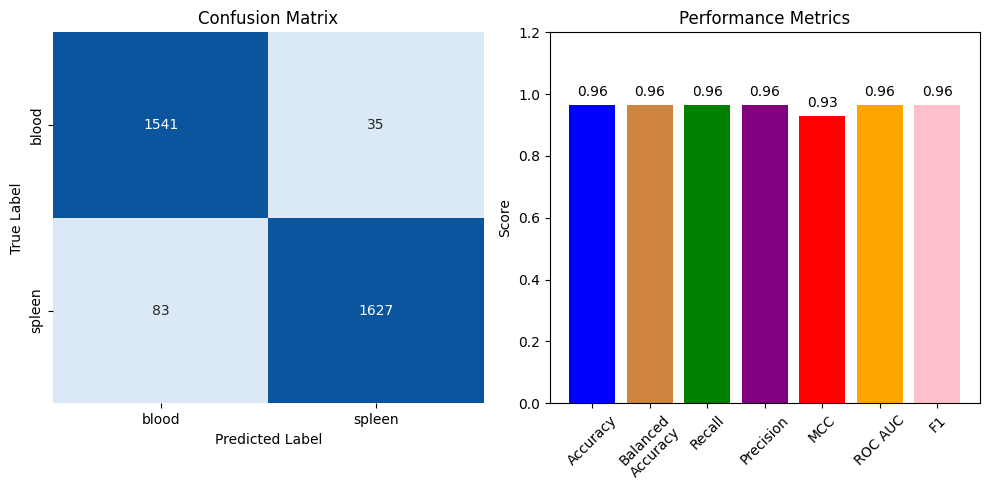

[I 2024-07-22 13:20:11,629] A new study created in memory with name: no-name-6810922f-1e27-4b57-85b9-946318f6a730



Optimizing Logistic Regression...



[I 2024-07-22 13:20:51,284] Trial 0 finished with value: 0.9825508386445774 and parameters: {'C': 3637.6982689190677, 'penalty': 'l2'}. Best is trial 0 with value: 0.9825508386445774.
[I 2024-07-22 13:21:29,121] Trial 1 finished with value: 0.983159769771728 and parameters: {'C': 28.289917952033736, 'penalty': 'l2'}. Best is trial 1 with value: 0.983159769771728.
[I 2024-07-22 13:21:48,522] Trial 2 finished with value: 0.9835656552135994 and parameters: {'C': 0.0007145486564518063, 'penalty': 'l2'}. Best is trial 2 with value: 0.9835656552135994.
[I 2024-07-22 13:22:26,335] Trial 3 finished with value: 0.9829567240864489 and parameters: {'C': 17.98399783090763, 'penalty': 'l2'}. Best is trial 2 with value: 0.9835656552135994.
[I 2024-07-22 13:23:07,982] Trial 4 finished with value: 0.9827538843298566 and parameters: {'C': 270.7035691781573, 'penalty': 'l2'}. Best is trial 2 with value: 0.9835656552135994.
[I 2024-07-22 13:23:54,291] Trial 5 finished with value: 0.9825508386445774 and p


Best parameters for Logistic Regression: {'C': 0.0007145486564518063, 'penalty': 'l2'}

Logistic Regression performance



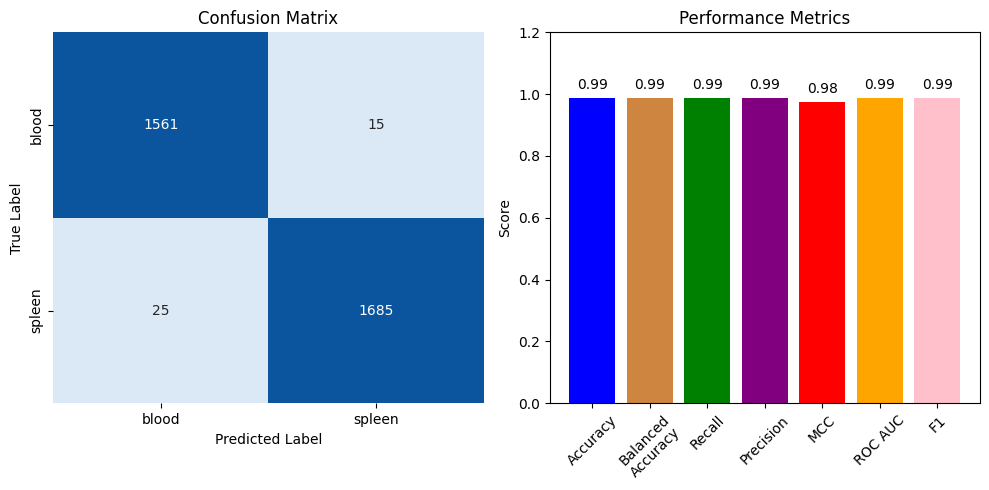

[I 2024-07-22 13:26:35,369] A new study created in memory with name: no-name-57efca95-db44-4f9c-82b0-e511ed9699f6



Optimizing KNN...



[I 2024-07-22 13:26:51,081] Trial 0 finished with value: 0.650032639696873 and parameters: {'n_neighbors': 11, 'weights': 'uniform'}. Best is trial 0 with value: 0.650032639696873.
[I 2024-07-22 13:27:04,626] Trial 1 finished with value: 0.5924049381699117 and parameters: {'n_neighbors': 4, 'weights': 'uniform'}. Best is trial 0 with value: 0.650032639696873.
[I 2024-07-22 13:27:17,798] Trial 2 finished with value: 0.6940612225986141 and parameters: {'n_neighbors': 15, 'weights': 'distance'}. Best is trial 2 with value: 0.6940612225986141.
[I 2024-07-22 13:27:31,832] Trial 3 finished with value: 0.7303777761761102 and parameters: {'n_neighbors': 19, 'weights': 'uniform'}. Best is trial 3 with value: 0.7303777761761102.
[I 2024-07-22 13:27:44,784] Trial 4 finished with value: 0.7332138260520382 and parameters: {'n_neighbors': 18, 'weights': 'uniform'}. Best is trial 4 with value: 0.7332138260520382.
[I 2024-07-22 13:27:59,370] Trial 5 finished with value: 0.6283232256669515 and paramete


Best parameters for KNN: {'n_neighbors': 18, 'weights': 'uniform'}

KNN performance



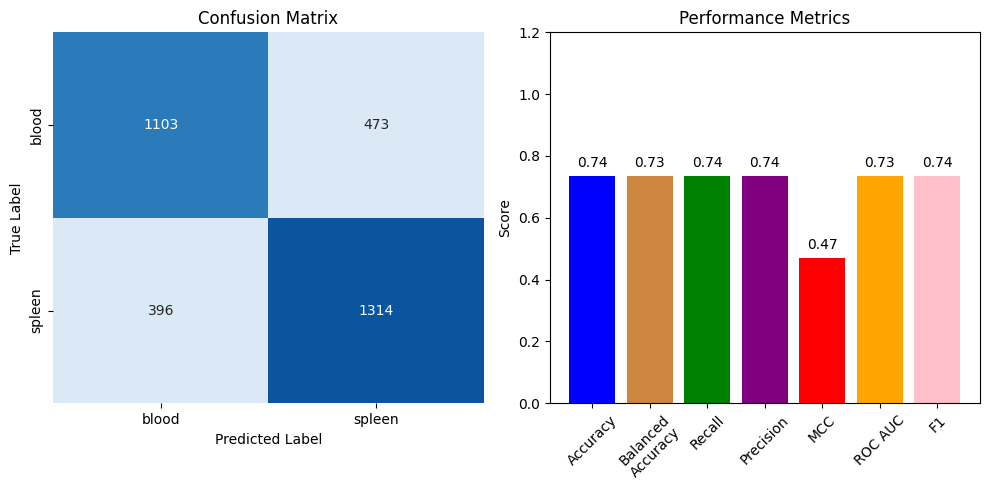

In [20]:
optimizer = ModelOptimizer(X_train, y_train_encoded, X_test, y_test_encoded, random_state=42, label_encoder=label_encoder)

best_accs = {}

for clf in classifiers:
    if clf == 'SVC': # kernel crushes
        continue
    print(f"\n\033[1mOptimizing {clf}...\033[0m\n")
    best_params = optimizer.optimize(clf, n_trials=10)
    print(f"\nBest parameters for {clf}: {best_params}")
    print(f"\n\033[1m{clf} performance\033[0m\n")
    metrics = optimizer.evaluate(clf)
    best_accs[clf] = metrics['accuracy']

**Feature Selection**

[I 2024-07-22 13:29:04,544] A new study created in memory with name: no-name-f0155475-c885-4232-8c02-d29b05dfb102



Optimizing Random Forest



[I 2024-07-22 13:29:09,804] Trial 0 finished with value: 0.9259490738357308 and parameters: {'n_estimators': 173, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9259490738357308.
[I 2024-07-22 13:29:13,604] Trial 1 finished with value: 0.9269634785473789 and parameters: {'n_estimators': 127, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9269634785473789.
[I 2024-07-22 13:29:15,765] Trial 2 finished with value: 0.9340636937428568 and parameters: {'n_estimators': 58, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.9340636937428568.
[I 2024-07-22 13:29:20,977] Trial 3 finished with value: 0.9350783043831921 and parameters: {'n_estimators': 147, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.9350783043831921.
[I 2024-07-22 13:29:24,561] Trial 4 finished with value: 0.9356870295816557 and parameters: {'n


Best parameters for Random Forest: {'n_estimators': 78, 'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 4}

Random Forest performance



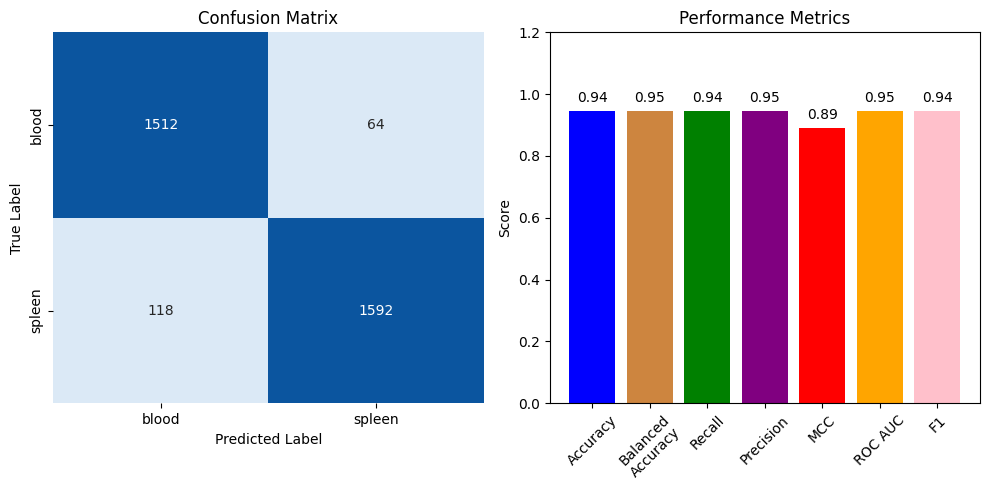

[I 2024-07-22 13:29:55,423] A new study created in memory with name: no-name-2cd18cad-5982-4399-800b-225874d78a57
[I 2024-07-22 13:29:55,534] Trial 0 finished with value: 0.9415710299523277 and parameters: {'C': 20692.11436346783, 'penalty': 'l2'}. Best is trial 0 with value: 0.9415710299523277.



Optimizing Logistic Regression



[I 2024-07-22 13:29:55,672] Trial 1 finished with value: 0.9415710299523277 and parameters: {'C': 6.134427423867683, 'penalty': 'l2'}. Best is trial 0 with value: 0.9415710299523277.
[I 2024-07-22 13:29:55,782] Trial 2 finished with value: 0.9421787255073568 and parameters: {'C': 0.035555324798648535, 'penalty': 'l2'}. Best is trial 2 with value: 0.9421787255073568.
[I 2024-07-22 13:29:55,892] Trial 3 finished with value: 0.9371060841630543 and parameters: {'C': 0.0030811973290593474, 'penalty': 'l2'}. Best is trial 2 with value: 0.9421787255073568.
[I 2024-07-22 13:29:56,032] Trial 4 finished with value: 0.9415710299523277 and parameters: {'C': 32933.240286578904, 'penalty': 'l2'}. Best is trial 2 with value: 0.9421787255073568.
[I 2024-07-22 13:29:56,179] Trial 5 finished with value: 0.9415710299523277 and parameters: {'C': 254.82244466257683, 'penalty': 'l2'}. Best is trial 2 with value: 0.9421787255073568.
[I 2024-07-22 13:29:56,327] Trial 6 finished with value: 0.9425852287352889 


Best parameters for Logistic Regression: {'C': 0.3223215016719074, 'penalty': 'l2'}

Logistic Regression performance



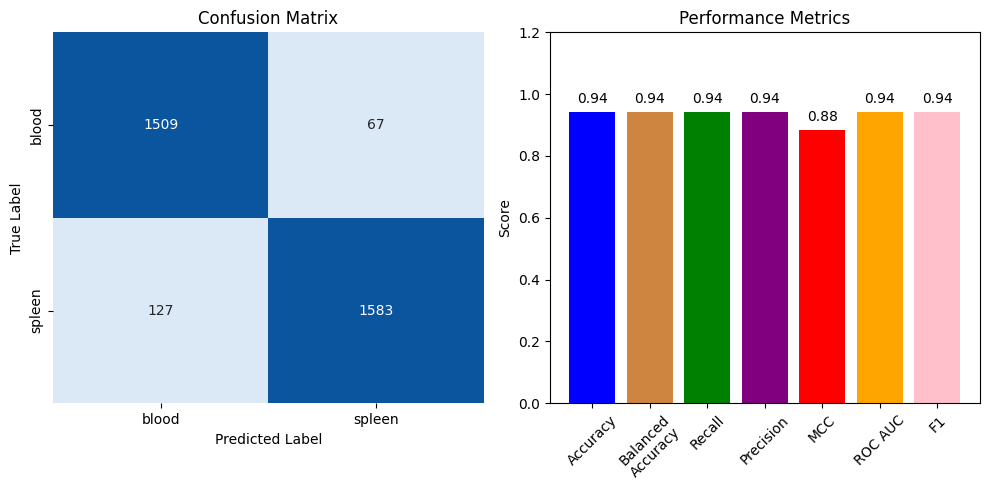

[I 2024-07-22 13:29:57,074] A new study created in memory with name: no-name-ec1579f2-ffb8-480b-8028-cb5b80d57bd9
[I 2024-07-22 13:29:57,203] Trial 0 finished with value: 0.9196583643084401 and parameters: {'n_neighbors': 7, 'weights': 'uniform'}. Best is trial 0 with value: 0.9196583643084401.



Optimizing KNN



[I 2024-07-22 13:29:57,337] Trial 1 finished with value: 0.9131662565253652 and parameters: {'n_neighbors': 6, 'weights': 'uniform'}. Best is trial 0 with value: 0.9196583643084401.
[I 2024-07-22 13:29:57,473] Trial 2 finished with value: 0.9194557304805345 and parameters: {'n_neighbors': 6, 'weights': 'distance'}. Best is trial 0 with value: 0.9196583643084401.
[I 2024-07-22 13:29:57,637] Trial 3 finished with value: 0.9206727690200884 and parameters: {'n_neighbors': 18, 'weights': 'distance'}. Best is trial 3 with value: 0.9206727690200884.
[I 2024-07-22 13:29:57,788] Trial 4 finished with value: 0.9168171662153398 and parameters: {'n_neighbors': 16, 'weights': 'uniform'}. Best is trial 3 with value: 0.9206727690200884.
[I 2024-07-22 13:29:57,937] Trial 5 finished with value: 0.9196579524510662 and parameters: {'n_neighbors': 15, 'weights': 'uniform'}. Best is trial 3 with value: 0.9206727690200884.
[I 2024-07-22 13:29:58,087] Trial 6 finished with value: 0.9212812882898651 and param


Best parameters for KNN: {'n_neighbors': 11, 'weights': 'uniform'}

KNN performance



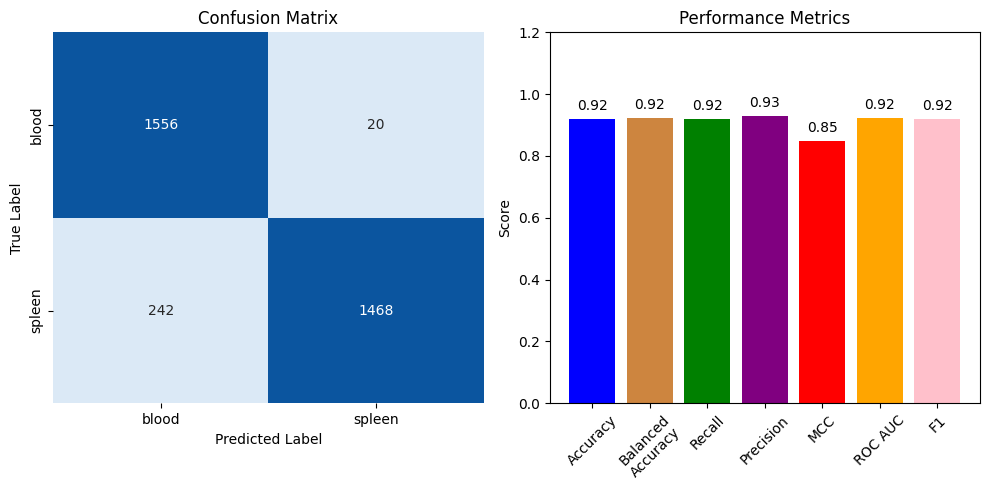

[I 2024-07-22 13:29:59,188] A new study created in memory with name: no-name-b661ea13-232c-48f0-b891-2ce396cba7b4



Optimizing SVC



[I 2024-07-22 13:30:04,309] Trial 0 finished with value: 0.5199837316337353 and parameters: {'C': 0.00021644325127165228, 'gamma': 0.05518643912714549}. Best is trial 0 with value: 0.5199837316337353.
[I 2024-07-22 13:30:05,673] Trial 1 finished with value: 0.9415708240236407 and parameters: {'C': 363421.161118198, 'gamma': 1.8903775708237008e-07}. Best is trial 1 with value: 0.9415708240236407.
[I 2024-07-22 13:32:46,987] Trial 2 finished with value: 0.9369028325490882 and parameters: {'C': 4664657.8587962035, 'gamma': 5.452387330964327e-05}. Best is trial 1 with value: 0.9415708240236407.
[I 2024-07-22 13:32:51,703] Trial 3 finished with value: 0.5199837316337353 and parameters: {'C': 3.897130015466664, 'gamma': 7.448917571175301e-07}. Best is trial 1 with value: 0.9415708240236407.
[I 2024-07-22 13:32:57,253] Trial 4 finished with value: 0.5199837316337353 and parameters: {'C': 0.06206801392571344, 'gamma': 1.7767472919543998}. Best is trial 1 with value: 0.9415708240236407.
[I 2024


Best parameters for SVC: {'C': 363421.161118198, 'gamma': 1.8903775708237008e-07}

SVC performance



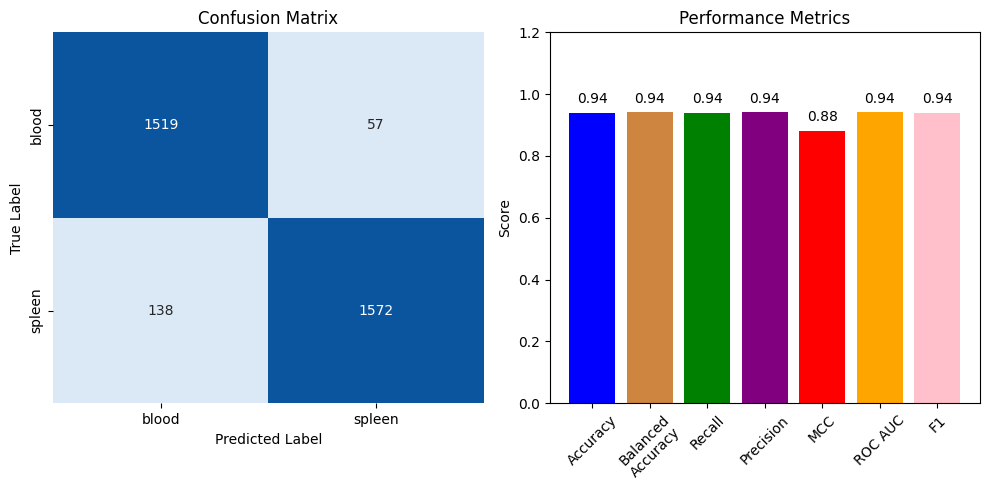

In [21]:
optimizer_fs = ModelOptimizer(X_train_fs, y_train_encoded, X_test_fs, y_test_encoded, random_state=42, label_encoder=label_encoder)

best_accs_fs = {}

for clf in classifiers:
    print(f"\n\033[1mOptimizing {clf}\033[0m\n")
    best_params_fs = optimizer_fs.optimize(clf, n_trials=10)
    print(f"\nBest parameters for {clf}: {best_params_fs}")
    print(f"\n\033[1m{clf} performance\033[0m\n")
    metrics = optimizer_fs.evaluate(clf)
    best_accs_fs[clf] = metrics['accuracy']

In [22]:
# A function to plot metrics of the classifiers over optuna trials (in this case the average accuracy of the 5fold cross validation)

def plot_trial_metrics(dict):
    
    df = pd.DataFrame.from_dict(dict)
    color_num = len(df.transpose())
    palette = sns.color_palette("husl", color_num)

    long_df = df.melt(var_name='Classifier', value_name='Score')
    
    # Create the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Classifier', y='Score', data=long_df, palette=palette)
    plt.title('Boxplot of Classifier Scores')
    plt.xlabel('Classifier')
    plt.ylabel('Score')
    plt.show()

**No feature selection**

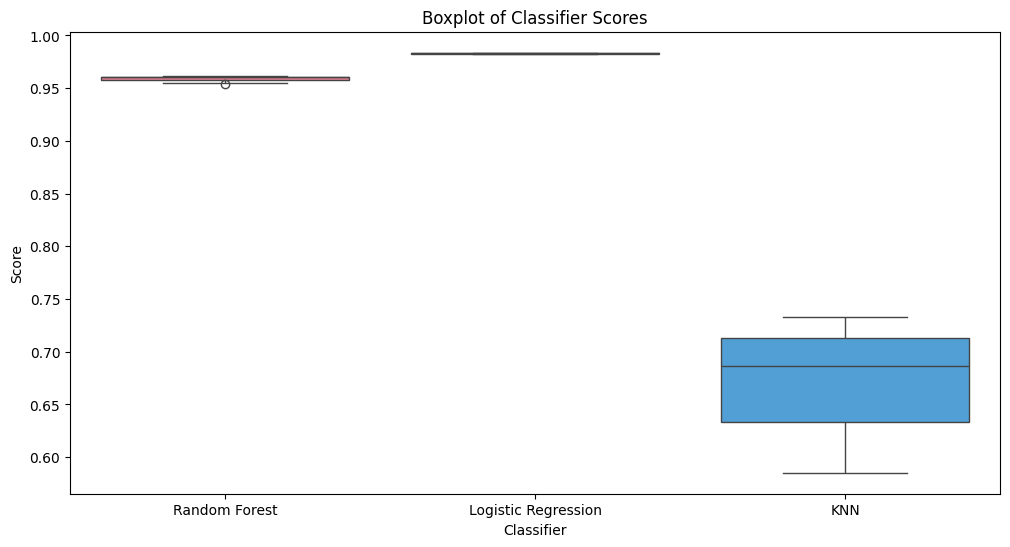

In [23]:
plot_trial_metrics(optimizer.trial_metrics)

**Feature selection**

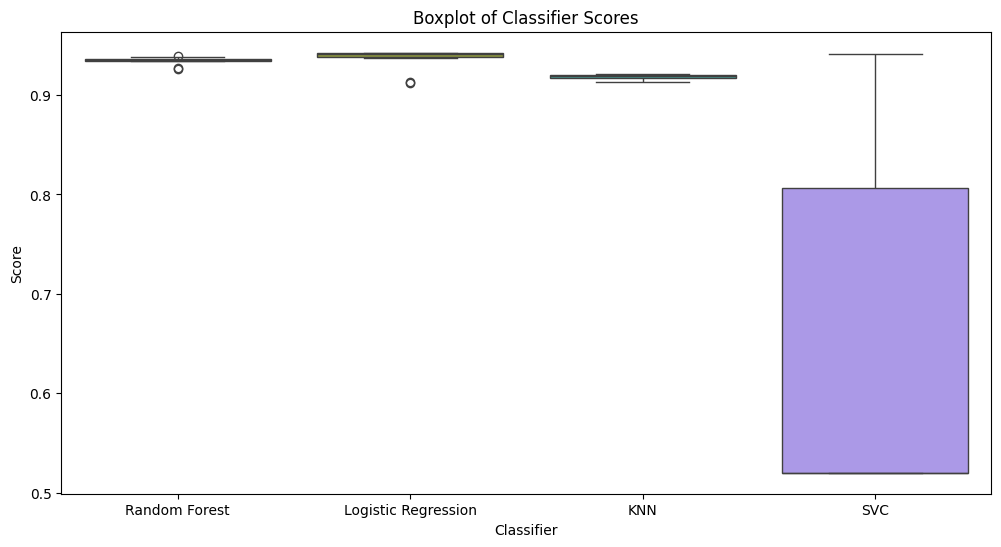

In [24]:
plot_trial_metrics(optimizer_fs.trial_metrics)

In [36]:
# Best model parameters without feature selection

optimizer.best_models

{'Random Forest': {'n_estimators': 196,
  'max_depth': 9,
  'min_samples_split': 7,
  'min_samples_leaf': 3},
 'Logistic Regression': {'C': 0.0007145486564518063, 'penalty': 'l2'},
 'KNN': {'n_neighbors': 18, 'weights': 'uniform'}}

In [27]:
# Best model parameters for feature selection

optimizer_fs.best_models

{'Random Forest': {'n_estimators': 78,
  'max_depth': 10,
  'min_samples_split': 18,
  'min_samples_leaf': 4},
 'Logistic Regression': {'C': 0.3223215016719074, 'penalty': 'l2'},
 'KNN': {'n_neighbors': 11, 'weights': 'uniform'},
 'SVC': {'C': 363421.161118198, 'gamma': 1.8903775708237008e-07}}

**Select model**

Among the classifiers tested, Logistic Regression is the simplest and serves as the baseline model. Its straightforward and computationally efficient nature makes it ideal for initial assessments. Following the principles of parsimonious modeling, which aim to achieve optimal performance with the simplest model, Logistic Regression meets these criteria effectively. It performs strongly both with and without feature selection, making it suitable for our dataset and task. Its simplicity and high accuracy make it the recommended model for our classification task.
We chose to save the model with feature selection due to its computational efficiency and the negligible difference in accuracy compared to the non-feature-selected model. This decision ensures high performance while optimizing resource usage, further reinforcing Logistic Regression as the practical choice for this analysis.

In [33]:
winner_params = optimizer_fs.best_models['Logistic Regression']
winner_model = LogisticRegression(**winner_params, random_state=optimizer.random_state)
winner_model.fit(X_train_fs, y_train_encoded)
# !mkdir models
import joblib
joblib.dump(winner_model, 'models/logistic_regression_model.pkl')
print("Model saved to 'models/logistic_regression_model.pkl'")

Model saved to 'models/logistic_regression_model.pkl'


In [37]:
best_accs

{'Random Forest': 0.9640900791235545,
 'Logistic Regression': 0.9878271454656117,
 'KNN': 0.7355447352404139}

In [38]:
best_accs_fs

{'Random Forest': 0.9446135118685332,
 'Logistic Regression': 0.9409616555082166,
 'KNN': 0.9202678027997565,
 'SVC': 0.940657334144857}

: 